# Financial Inclusion in Africa

Here we are going to describe and implement a solution to predicting whether an individual features
set is likely to have a back account or not.

In [468]:
# for data processing
import pandas as pd
import tensorflow as tf
import seaborn as sns

# for display
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# for machine learning
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# for io
# from google.colab import files
import warnings

warnings.filterwarnings('ignore')

##### Read files

In [469]:
# load files into a pandas dataframe

train = pd.read_csv('assets/Train.csv')
test = pd.read_csv('assets/Test.csv')
ss = pd.read_csv('assets/SampleSubmission.csv')
variables = pd.read_csv('assets/VariableDefinitions.csv')

##### Some basic EDA

In [470]:
# Let's view the variables
variables

,Variable Definitions,Unnamed: 1
0,country,Country interviewee is in.
1,year,Year survey was done in.
2,uniqueid,Unique identifier for each interviewee
3,location_type,"Type of location: Rural, Urban"
4,cellphone_access,"If interviewee has access to a cellphone: Yes, No"
5,household_size,Number of people living in one house
6,age_of_respondent,The age of the interviewee
7,gender_of_respondent,"Gender of interviewee: Male, Female"
8,relationship_with_head,The interviewee’s relationship with the head o...
9,marital_status,The martial status of the interviewee: Married...


##### A Preview of the training data

In [471]:
train.head()

,country,year,uniqueid,bank_account,location_type,cellphone_access,household_size,age_of_respondent,gender_of_respondent,relationship_with_head,marital_status,education_level,job_type
0,Kenya,2018,uniqueid_1,Yes,Rural,Yes,3,24,Female,Spouse,Married/Living together,Secondary education,Self employed
1,Kenya,2018,uniqueid_2,No,Rural,No,5,70,Female,Head of Household,Widowed,No formal education,Government Dependent
2,Kenya,2018,uniqueid_3,Yes,Urban,Yes,5,26,Male,Other relative,Single/Never Married,Vocational/Specialised training,Self employed
3,Kenya,2018,uniqueid_4,No,Rural,Yes,5,34,Female,Head of Household,Married/Living together,Primary education,Formally employed Private
4,Kenya,2018,uniqueid_5,No,Urban,No,8,26,Male,Child,Single/Never Married,Primary education,Informally employed


##### Preview the first five rows of the sample submission file

In [472]:
ss.head()

,unique_id,bank_account
0,uniqueid_1 x Kenya,0
1,uniqueid_2 x Kenya,0
2,uniqueid_3 x Kenya,0
3,uniqueid_4 x Kenya,0
4,uniqueid_5 x Kenya,0


## Combine train and test set for easy preprocessing

In [473]:
# mapping the bank account with 0 to NO and 1 to YES
train['bank_account'] = train['bank_account'].map({'No':0, 'Yes':1})

In [474]:
# Combine train and test set
ntrain = train.shape[0] # to be used to split train and test set from the combined dataframe

all_data = pd.concat((train, test)).reset_index(drop=True)
print(f'The shape of the combined dataframe is: {all_data.shape}')

The shape of the combined dataframe is: (33610, 13)


### Feature Engineering

In [475]:
cat_cols = ['country',	'location_type',	'cellphone_access',	'gender_of_respondent',	'relationship_with_head', 'marital_status', 'education_level',	'job_type']

# Encode categorical features
all_data = pd.get_dummies(data = all_data, columns = cat_cols)
all_data.head()

,year,uniqueid,bank_account,household_size,age_of_respondent,country_Kenya,country_Rwanda,country_Tanzania,country_Uganda,location_type_Rural,...,job_type_Dont Know/Refuse to answer,job_type_Farming and Fishing,job_type_Formally employed Government,job_type_Formally employed Private,job_type_Government Dependent,job_type_Informally employed,job_type_No Income,job_type_Other Income,job_type_Remittance Dependent,job_type_Self employed
0,2018,uniqueid_1,1.0,3,24,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,2018,uniqueid_2,0.0,5,70,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,2018,uniqueid_3,1.0,5,26,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,2018,uniqueid_4,0.0,5,34,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
4,2018,uniqueid_5,0.0,8,26,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [476]:
# Separate train and test data from the combined dataframe
train_df = all_data[:ntrain]
test_df = all_data[ntrain:]

We select the required columns that we will have in our input data set.
- We remove the uniqueid because it means nothing to the required output.
- We also remove the bank_account information because it has no organic output.
- We remove the year because time series information may cause the data fitting to overfit.

In [477]:
# Select main columns to be used in training
main_cols = all_data.columns.difference(['uniqueid', 'bank_account'])
x = train_df[main_cols]
y = train_df['bank_account']
# lets take a look now
x.head()

# Split data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

### Model Training

We now start modelling and training. We are going to the keras Sequential model to construct and
fit our input data set.

In [478]:
# Model compilation.
model = XGBClassifier(n_estimators=2400, eta=0.01, verbosity=0, subsample=0.1, colsample_bytree=0.1)
eval_s = [(x, y), (x_test, y_test)]
model.fit(x_train, y_train, eval_set=eval_s)

y_pred = model.predict(x_test)

print(f'XGB model accuracy: {accuracy_score(y_test, y_pred)*100}%')

[0]	validation_0-logloss:0.68781	validation_1-logloss:0.68781
[1]	validation_0-logloss:0.68241	validation_1-logloss:0.68241
[2]	validation_0-logloss:0.67720	validation_1-logloss:0.67718
[3]	validation_0-logloss:0.67222	validation_1-logloss:0.67219
[4]	validation_0-logloss:0.66702	validation_1-logloss:0.66695
[5]	validation_0-logloss:0.66195	validation_1-logloss:0.66183
[6]	validation_0-logloss:0.65725	validation_1-logloss:0.65711
[7]	validation_0-logloss:0.65261	validation_1-logloss:0.65250
[8]	validation_0-logloss:0.64816	validation_1-logloss:0.64802
[9]	validation_0-logloss:0.64337	validation_1-logloss:0.64320
[10]	validation_0-logloss:0.63915	validation_1-logloss:0.63896
[11]	validation_0-logloss:0.63449	validation_1-logloss:0.63429
[12]	validation_0-logloss:0.63005	validation_1-logloss:0.62981
[13]	validation_0-logloss:0.62604	validation_1-logloss:0.62577
[14]	validation_0-logloss:0.62183	validation_1-logloss:0.62155
[15]	validation_0-logloss:0.61760	validation_1-logloss:0.61728
[1

### Making predictions of the test set and creating a submission file

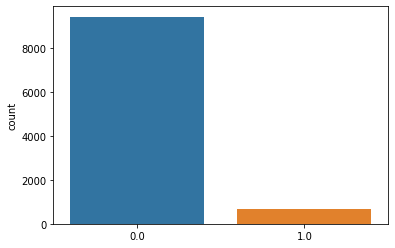

In [479]:
# Make prediction on the test set
test_df = test_df[main_cols]
predictions = model.predict(test_df.to_numpy())

# Create a submission file
sub_file = ss.copy()
sub_file.predictions = predictions

# Check the distribution of your predictions
sns.countplot(sub_file.predictions);

In [480]:
# Create a csv file and upload to zindi
sub_file.to_csv('Baseline.csv', index = False)

### Optimization

We plot learning rate to tune and optimize our learning algorithm

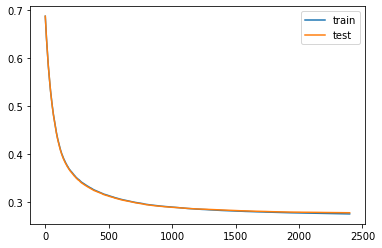

In [481]:
results = model.evals_result()
# files.download('Baseline.csv')
plt.plot(results['validation_0']['logloss'], label='train')
plt.plot(results['validation_1']['logloss'], label='test')
# show the legend
plt.legend()
# show the plot
plt.show()